In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import keras
import tensorflow as tf
from keras import models, layers, optimizers, callbacks, regularizers, initializers

In [19]:
df = pd.read_csv('./dataset_preprocessed/tabular/no_outliers_tracks.csv')

In [20]:
X = df.drop(columns=[
    'id',
    'name',
    'disc_number',
    'explicit',
    'artists',
    'album_type',
    'album_name',
    'album_release_date',
    'album_release_date_precision',
    'key',
    'mode',
    'time_signature',
    'genre']).values

y = df['explicit'].values.astype(int)

In [21]:
feature_names = df.drop(columns=[
    'id',
    'name',
    'disc_number',
    'explicit',
    'artists',
    'album_type',
    'album_name',
    'album_release_date',
    'album_release_date_precision',
    'key',
    'mode',
    'time_signature',
    'genre']).columns.to_list()

feature_names

['duration_ms',
 'popularity',
 'album_total_tracks',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'tempo_confidence',
 'time_signature_confidence',
 'key_confidence']

# Classifier training

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2, 
                                                  random_state=0, 
                                                  shuffle=True, 
                                                  stratify=y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [23]:
def my_nn(hidden_layers, activation, lr, reg_type, reg_penalty=0.01, momentum=0):
    model = models.Sequential()

    model.add(keras.layers.Input(shape=(15,)))
    for layer_size in hidden_layers:
        model.add(layers.Dense(units=layer_size,
                               activation=activation,
                               kernel_regularizer=reg_type(reg_penalty)))

    # Output layer
    model.add(layers.Dense(units=1,
                           activation='sigmoid',
                           kernel_regularizer=reg_type(reg_penalty)))
    
    optimizer=optimizers.SGD(learning_rate=lr, momentum=momentum)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,        
        metrics=['accuracy']
    )
    return model

In [24]:
nn = my_nn(hidden_layers=[4, 8],
           activation='relu',
           lr=0.01,
           reg_type=regularizers.l1,
           reg_penalty=0.01,
           momentum=0.9,
           )

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, verbose=True)
mc = callbacks.ModelCheckpoint('best_model_NOREG.keras', monitor='val_loss', save_best_only=True)

tf.random.set_seed(1)
# Calculate class weights
class_weight = {0: (1/np.sum(y_train == 0)) * len(y_train) / 2.0,
                 1: (1/np.sum(y_train == 1)) * len(y_train) / 2.0}

nn.fit(X_train_scaled,
       y_train,
       epochs=500,
       batch_size=2048,
       shuffle=True,
       class_weight=class_weight,
       validation_data=(X_val_scaled, y_val),
       callbacks=[es, mc])

Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3137 - loss: 1.1298 - val_accuracy: 0.7721 - val_loss: 0.8875
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7694 - loss: 0.9462 - val_accuracy: 0.7273 - val_loss: 0.9028
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7221 - loss: 0.8814 - val_accuracy: 0.7182 - val_loss: 0.8705
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7240 - loss: 0.8313 - val_accuracy: 0.7250 - val_loss: 0.8315
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7286 - loss: 0.7895 - val_accuracy: 0.7334 - val_loss: 0.7947
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7366 - loss: 0.7551 - val_accuracy: 0.7374 - val_loss: 0.7636
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7399 - loss: 0.7278 - val_accuracy: 0.7431 - val_loss: 0.7366
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7445 - loss: 0.7072 - val_accuracy: 0.7474 - 

In [25]:
y_pred = nn.predict(X_test_scaled)

556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [26]:
y_pred = np.round(y_pred).reshape(-1)

In [27]:
# We get the indexes of the training examples which were misclassified
misclassified = X_test[y_test != y_pred]
misclassified_scaled = X_test_scaled[y_test != y_pred]
# and those correctly classified
correct = X_test[y_test == y_pred]
correct_scaled = X_test_scaled[y_test == y_pred]

In [28]:
# Misclassified as negative
print('Prediction: ', nn.predict(misclassified_scaled[0].reshape(1, -1)))

# Misclassified as positive
print('Prediction: ', nn.predict(misclassified_scaled[1].reshape(1, -1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Prediction:  [[0.34439492]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction:  [[0.5901529]]


In [29]:
print('Prediction: ', nn.predict(correct_scaled[0].reshape(1, -1)))

print('Prediction: ', nn.predict(correct_scaled[10].reshape(1, -1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction:  [[0.35727412]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction:  [[0.83851963]]


# Global methods

In [13]:
y_pred = nn.predict(X_test_scaled)
y_pred = np.round(y_pred).reshape(-1)

explainer = DecisionTreeClassifier(max_depth=4)
explainer.fit(X_test, y_pred)

556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step


DecisionTreeClassifier(max_depth=4)

In [15]:
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and
            inner_tree.children_right[index] == TREE_LEAF)


def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        # print("Pruned {}".format(index))


def prune_duplicate_leaves(dt):
    # Remove leaves if both
    decisions = dt.tree_.value.argmax(axis=2).flatten().tolist()  # Decision for each node
    prune_index(dt.tree_, decisions)

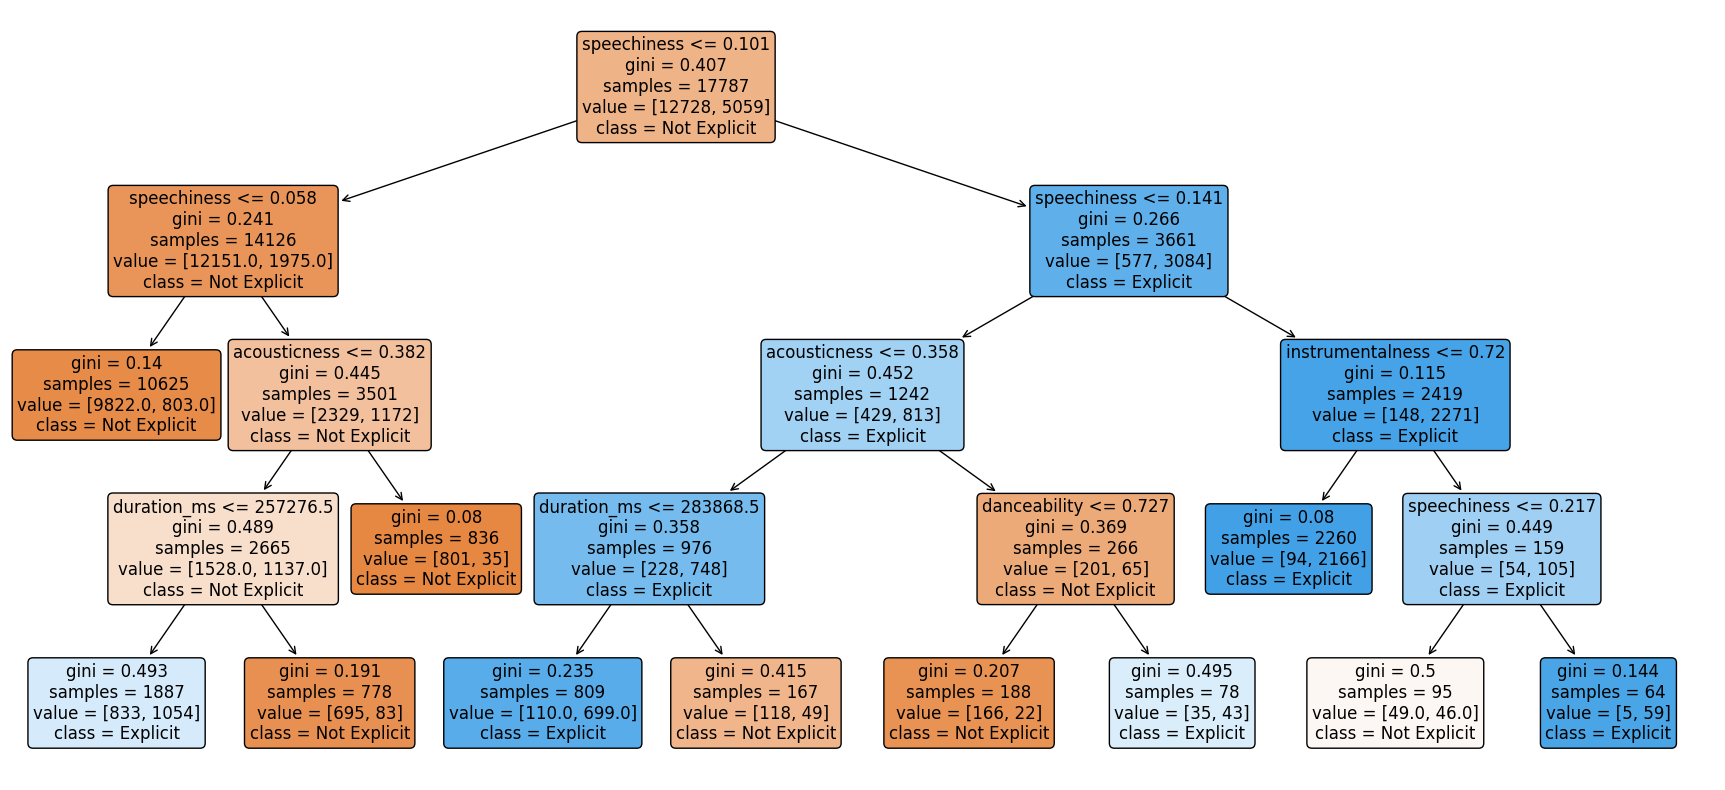

In [16]:
plt.figure(figsize=(22, 10))

prune_duplicate_leaves(explainer)

plot_tree(explainer, 
          feature_names=feature_names, 
          class_names=['Not Explicit', 'Explicit'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=4)
plt.savefig('./img/XAI/decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

# Local methods

## SHAP

In [30]:
import shap
shap.initjs()

In [31]:
x1 = misclassified_scaled[0]
x2 = misclassified_scaled[1]

x3 = correct_scaled[0]
x4 = correct_scaled[10]

X = np.array([x1, x2, x3, x4])

In [32]:
# Explain the model's predictions using SHAP
explainer = shap.KernelExplainer(nn.predict, X_train_scaled)

1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Using 56917 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [33]:
shap_values = explainer.shap_values(X, nsamples=150)

  0%|          | 0/4 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
266799/266799 ━━━━━━━━━━━━━━━━━━━━ 241s 902us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
266799/266799 ━━━━━━━━━━━━━━━━━━━━ 276s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
266799/266799 ━━━━━━━━━━━━━━━━━━━━ 268s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
266799/266799 ━━━━━━━━━━━━━━━━━━━━ 308s 1ms/step


In [34]:
shap_values.shape

(4, 15, 1)

In [35]:
shap_values = shap_values.reshape(len(X),15)
shap_values

array([[-1.65080796e-02,  1.35587486e-02,  4.18200956e-03,
         4.75350694e-02,  6.12674270e-04,  1.86462119e-02,
        -8.93826925e-02,  4.59780411e-03,  3.05614989e-02,
         4.11610711e-03, -1.48143966e-02, -1.55200919e-03,
        -1.88913312e-02, -3.64707576e-03, -3.20341038e-03],
       [ 8.17595437e-02,  9.42250278e-04,  0.00000000e+00,
         6.92604107e-02, -1.26496487e-04, -3.17620329e-02,
         1.62717381e-01, -3.22899042e-02,  3.03924135e-02,
         4.45312998e-03, -6.18312060e-02, -2.15393530e-03,
        -1.59858746e-02, -3.79015141e-03,  1.99835969e-02],
       [-4.72741798e-02, -1.18282279e-03,  1.44949887e-02,
         3.77478057e-02,  6.97431100e-04,  1.43280711e-03,
        -6.92996338e-02,  7.88534978e-02,  3.04839411e-02,
         5.67012892e-03, -5.82119994e-02,  0.00000000e+00,
        -2.04529054e-02,  1.97776255e-03,  1.37534998e-02],
       [ 1.08277223e-02,  3.97913176e-03,  7.66182911e-03,
        -2.80589158e-02,  0.00000000e+00, -2.25798260

In [45]:
for i, x in enumerate(X):
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[i], features=x, feature_names=feature_names, max_display=10, show=False)
    plt.savefig(f'./img/XAI/shap_{i}.png', dpi=300, bbox_inches='tight')

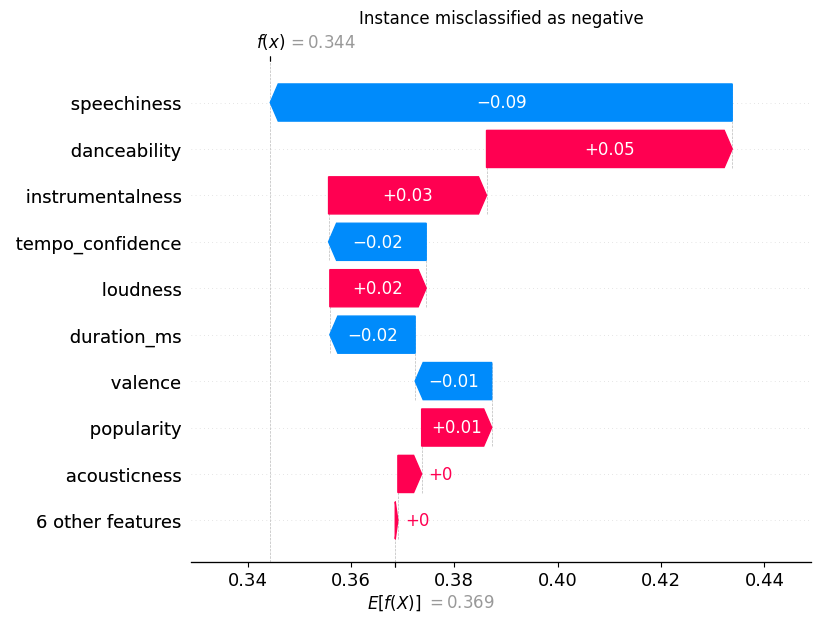

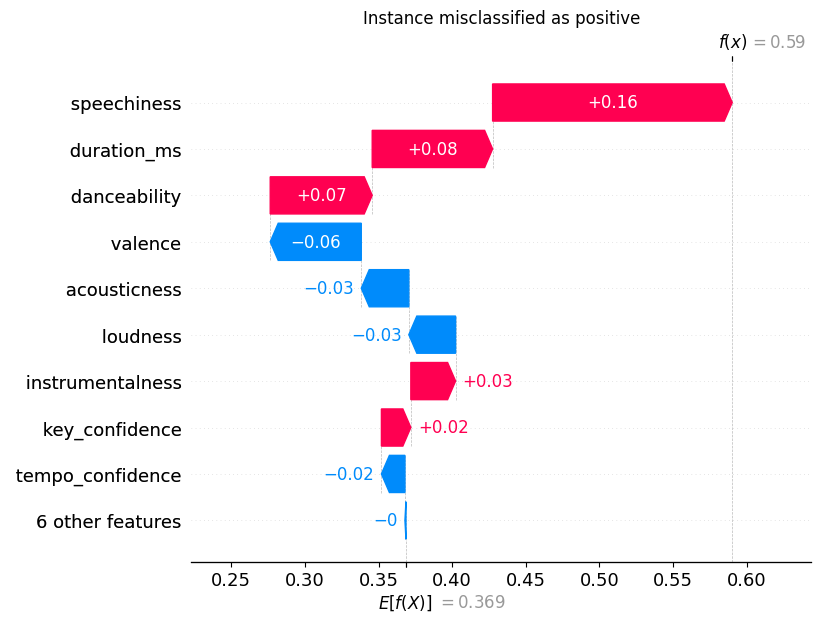

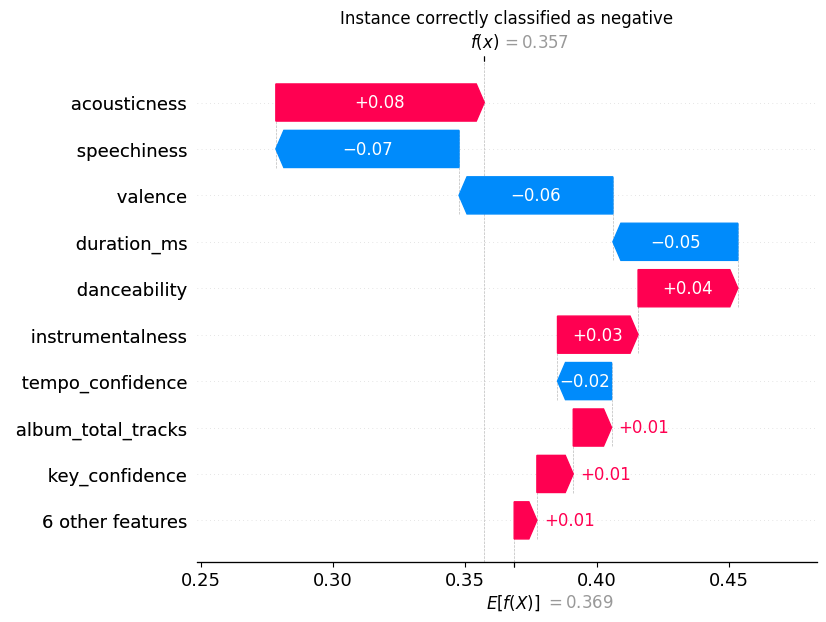

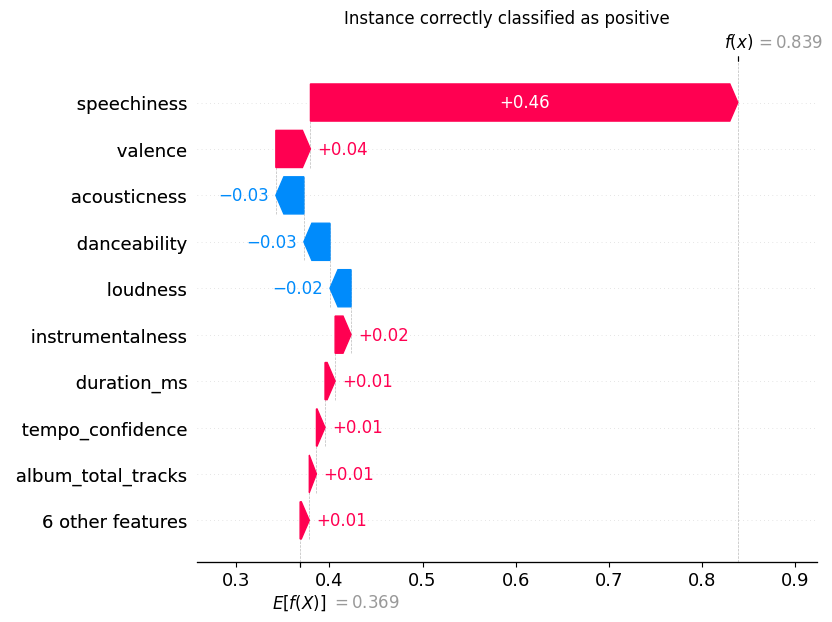

In [48]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0], features=x, feature_names=feature_names, max_display=10, show=False)
plt.title('Instance misclassified as negative')
plt.savefig(f'./img/XAI/shap_incorrect_neg.png', dpi=300, bbox_inches='tight')
plt.show()

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[1], features=x, feature_names=feature_names, max_display=10, show=False)
plt.title('Instance misclassified as positive')
plt.savefig(f'./img/XAI/shap_incorrect_pos.png', dpi=300, bbox_inches='tight')
plt.show()

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[2], features=x, feature_names=feature_names, max_display=10, show=False)
plt.title('Instance correctly classified as negative')
plt.savefig(f'./img/XAI/shap_correct_neg.png', dpi=300, bbox_inches='tight')
plt.show()

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[3], features=x, feature_names=feature_names, max_display=10, show=False)
plt.title('Instance correctly classified as positive')
plt.savefig(f'./img/XAI/shap_correct_pos.png', dpi=300, bbox_inches='tight')
plt.show()